In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from ModelSelection import *
from NeuralNetwork import *
from MyUtils import *

In [3]:
tr_df = pd.read_csv('../data/monks_csv/monks_tr_3.csv', index_col=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
len_training = len(tr_df)
test_df = pd.read_csv('../data/monks_csv/monks_ts_3.csv', index_col=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True) # test in realtà ma va be
len_test = len(test_df)
len_dataset = len_training + len_test
test_df.head(2)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1
0,3,2,2,3,4,1,0
1,3,1,1,1,4,2,0


In [4]:
def OHE(df):
    OHE = pd.get_dummies(df, columns=['input_'+str(i) for i in range(1, 7)])
    OHE = OHE.set_axis(['output_1'] + ['input_' + str(i) for i in range(1, len(OHE.columns))], axis=1)
    cols = OHE.columns.tolist()
    cols = cols[1:] + cols[:1]
    OHE = OHE[cols]
    return OHE

In [5]:
tr_df_OHE = OHE(tr_df)
test_df_OHE = OHE(test_df)

From monk database:

Attribute information:
1. class: 0, 1 
2. a1:    1, 2, 3
3. a2:    1, 2, 3
4. a3:    1, 2
5. a4:    1, 2, 3
6. a5:    1, 2, 3, 4
7. a6:    1, 2
8. Id:    (A unique symbol for each instance)

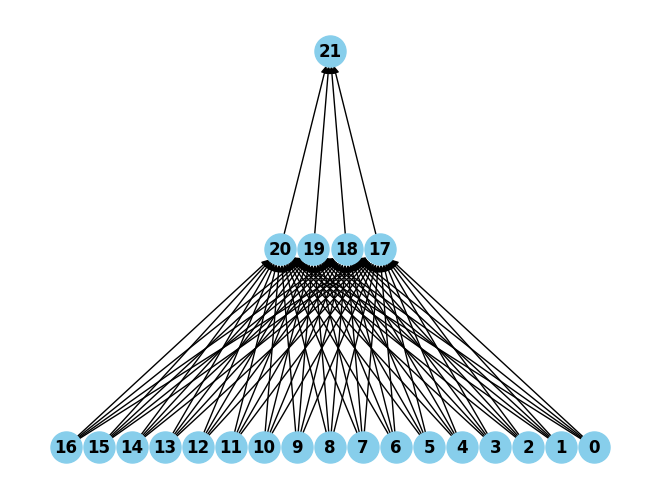

In [6]:
TR_INPUT = len(tr_df_OHE.columns) - 1
TR_OUTPUT = 1
hidden_len = 4
topology = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [['sigmoid', [1]]]*hidden_len + [['sigmoid', [1]]])
NeuralNetwork.display_topology(topology)

In [7]:
training_set = tr_df_OHE.values
test_set = test_df_OHE.values

In [7]:
np.seterr('raise')
MS = ModelSelection('../data/gs_data/monk_3_kf.csv')

MS.default_values['metrics'] = [ErrorFunctions.mean_squared_error, ErrorFunctions.accuracy]
hyperparam_grid = {
    'batch_size':[4, 8],
    'min_epochs': [50],
    'max_epochs':[600],
    'error_increase_tolerance':[0.0001],
    'patience':[10],
    
    'lambda_tikhonov':[0, 0.001, 0.0001],
    
    'learning_rate':[0.1, 0.3, 0.5],
    'alpha_momentum':[0.3, 0.6, 0.9],
    
    'topology': [str(topology)],
    'adamax' : [False],
}
MS.grid_searchKF(tr_df_OHE.values, hyperparam_grid, 5, 4, False, {})

Already done:  0
tot conf: 54
remaining conf: 54
tot conf to do: 54
pid: 58433  started new kfold 1 / 14
pid: 58459  started new kfold 1 / 14
pid: 58484  started new kfold 1 / 13
pid: 58509  started new kfold 1 / 13
pid: 58484  started new kfold 2 / 13
pid: 58509  started new kfold 2 / 13
pid: 58433  started new kfold 2 / 14
pid: 58459  started new kfold 2 / 14
pid: 58459  started new kfold 3 / 14
pid: 58484  started new kfold 3 / 13
pid: 58509  started new kfold 3 / 13
pid: 58433  started new kfold 3 / 14
pid: 58433  started new kfold 4 / 14
pid: 58459  started new kfold 4 / 14
pid: 58509  started new kfold 4 / 13
pid: 58484  started new kfold 4 / 13
pid: 58459  started new kfold 5 / 14
pid: 58433  started new kfold 5 / 14
pid: 58509  started new kfold 5 / 13
pid: 58484  started new kfold 5 / 13
pid: 58433  started new kfold 6 / 14
pid: 58459  started new kfold 6 / 14
pid: 58509  started new kfold 6 / 13
pid: 58484  started new kfold 6 / 13
pid: 58459  started new kfold 7 / 14
pid: 58

In [8]:
results_files = ['monk_3_test_kf.csv']
topologies = ['4_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)

orig_df = pd.concat(gs_results)
orig_df.head(1)

,adamax,alpha_momentum,batch_size,error_increase_tolerance,lambda_tikhonov,learning_rate,max_epochs,min_epochs,patience,topology,stats,mean_mean_squared_error,mean_accuracy,var_mean_squared_error,var_accuracy,mean_best_validation_training_error
0,False,0.3,4,0.0001,0.0,0.5,600,50,10,4_sigmoid,"{'lambda_tikhonov': 0, 'adamax': False, 'learn...",0.085264,0.9,0.001786,0.003194,0.030276


In [9]:
columns_order = [x for x in COLUMNS_ORDER if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_accuracy' 
orig_df.sort_values(by=[order_by], ascending=False, inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [10]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [11]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [12]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [13]:
error_treshold = 0.01
gs_results_clean = gs_results.loc[(gs_results['mean_accuracy'].notna()) & (gs_results['mean_accuracy'] > error_treshold)].copy()

gs_results_clean = gs_results_clean.reset_index(drop=True)
gs_results_clean.style.background_gradient(cmap='Blues')

,topology,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,adamax,mean_mean_squared_error,var_mean_squared_error,mean_accuracy,var_accuracy,mean_best_validation_training_error
0,4_sigmoid,8.000000,50.000000,600.000000,10.000000,0.000100,0.001000,0.300000,0.500000,0.000000,0.087404,0.001021,0.941667,0.002500,0.075405
1,4_sigmoid,4.000000,50.000000,600.000000,10.000000,0.000100,0.001000,0.300000,0.600000,0.000000,0.108153,0.000769,0.941667,0.002500,0.101498
2,4_sigmoid,4.000000,50.000000,600.000000,10.000000,0.000100,0.000100,0.100000,0.300000,0.000000,0.080162,0.000953,0.933333,0.001806,0.067727
3,4_sigmoid,4.000000,50.000000,600.000000,10.000000,0.000100,0.001000,0.100000,0.600000,0.000000,0.202993,0.000135,0.925000,0.000972,0.196124
4,4_sigmoid,8.000000,50.000000,600.000000,10.000000,0.000100,0.000100,0.100000,0.300000,0.000000,0.095039,0.001607,0.925000,0.003750,0.072231
5,4_sigmoid,8.000000,50.000000,600.000000,10.000000,0.000100,0.000100,0.500000,0.300000,0.000000,0.077931,0.001954,0.916667,0.003472,0.046466
6,4_sigmoid,8.000000,50.000000,600.000000,10.000000,0.000100,0.000100,0.100000,0.900000,0.000000,0.088448,0.001328,0.916667,0.001389,0.062820
7,4_sigmoid,8.000000,50.000000,600.000000,10.000000,0.000100,0.000100,0.300000,0.600000,0.000000,0.085271,0.001496,0.916667,0.004861,0.051180
8,4_sigmoid,4.000000,50.000000,600.000000,10.000000,0.000100,0.000100,0.100000,0.600000,0.000000,0.088176,0.000347,0.916667,0.001389,0.063729
9,4_sigmoid,4.000000,50.000000,600.000000,10.000000,0.000100,0.001000,0.300000,0.300000,0.000000,0.117350,0.000152,0.916667,0.000694,0.098883


In [14]:
#  best performance
n_best_fem = 1
sorting_values_col = ['mean_accuracy']
interesting_index = []
for i in topologies_dict:
    for col in sorting_values_col:
        interesting_index += list(orig_df.loc[orig_df['lambda_tikhonov'] == 0.0].sort_values([col], ascending=False).head(n_best_fem).index)
        interesting_index += list(orig_df.loc[orig_df['lambda_tikhonov'] != 0.0].sort_values([col], ascending=False).head(n_best_fem).index)
orig_df.iloc[interesting_index]

,topology,stats,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,adamax,mean_mean_squared_error,var_mean_squared_error,mean_accuracy,var_accuracy,mean_best_validation_training_error
14,4_sigmoid,"{'lambda_tikhonov': 0, 'adamax': False, 'learn...",4,50,600,10,0.0001,0.000,0.3,0.3,False,0.084323,0.002623,0.908333,0.003056,0.023068
0,4_sigmoid,"{'lambda_tikhonov': 0.001, 'adamax': False, 'l...",8,50,600,10,0.0001,0.001,0.3,0.5,False,0.087404,0.001021,0.941667,0.002500,0.075405


In [15]:
orig_df.iloc[0]['stats']

"{'lambda_tikhonov': 0.001, 'adamax': False, 'learning_rate': 0.0625, 'exp_decay_rate_2': 0.999, 'alpha_momentum': 0.9, 'error_increase_tolerance': 0.0001, 'exp_decay_rate_1': 0.9, 'patience': 10, 'training_set_len': 98, 'retraing_es_error': -1, 'max_epochs': 600, 'lr_decay_tau': 0, 'nesterov': False, 'minibatch_size': 8, 'min_epochs': 50, 'adamax_learning_rate': 0.00025, 'eta_tau': 0.000625, 'epochs': [600, 600, 600, 600, 600], 'mean_metrics': [0.08740385968637383, 0.9416666666666667], 'variance_metrics': [0.001020672314867775, 0.002500000000000001], 'mean_best_validation_training_error': 0.07540527839928066}"

In [16]:
def construct_obj(folder, index_list, df):
    interesting_model = []
    for i in index_list:
        
        dummy = {}
        dummy['nn_file_name'] = folder + df.iloc[i]['topology'] + '_' + str(i) + '.json'
        dummy['index'] = i
        df['metrics'] = [[ErrorFunctions.mean_squared_error, ErrorFunctions.accuracy]]*len(df)
        nn, stats = train_from_index(df, training_set.copy(), test_set.copy(), i, topologies_dict, False)
        dummy['model'] = nn
        dummy['stats'] = stats
        
        dummy['top_name'] = df.iloc[i]['topology']
        
        dummy['prediction_tr'] = nn.predict_array(training_set[:,:TR_INPUT])
        dummy['prediction_val'] = nn.predict_array(test_set[:,:TR_INPUT])
            
        dummy['tr_acc'] = ErrorFunctions.accuracy(dummy['prediction_tr'], training_set[:,TR_INPUT:])
        dummy['val_acc'] = ErrorFunctions.accuracy(dummy['prediction_val'], test_set[:,TR_INPUT:])

        interesting_model.append(dummy)
        
    return interesting_model

In [17]:
interesting_model = construct_obj('../data/net/monk_3/', interesting_index, orig_df)

starting values:  {'training_set_len': 122, 'minibatch_size': 4, 'max_epochs': 600, 'retraing_es_error': -1, 'error_increase_tolerance': 0.0001, 'patience': 10, 'min_epochs': 50, 'learning_rate': 0.075, 'lr_decay_tau': 0, 'eta_tau': 0.00075, 'lambda_tikhonov': 0.0, 'alpha_momentum': 0.3, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.0005, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999984), 'mean_epoch_train_time': 0, 'units_weights': {20: [], 19: [], 18: [], 17: [], 21: []}, 'units_weights_batch': {}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'training_accuracy': [], 'validation_accuracy': []}
[1/600] tr time: 0:00:00.121906 | mean_squared_error: tr=0.24562653961279135 val=0.2483473817328956 | | accuracy: tr=0.5081967213114754 val=0.4722222222222222 | 


[2/600] tr time: 0:00:00.080823 | mean_squared_error: tr=0.23987260415062747 val=0.2419108947893937 | | accuracy: tr=0.680327868852459 val=0.6180555555555556 | 
[3/600] tr time: 0:00:00.102202 | mean_squared_error: tr=0.23461224158808924 val=0.23675421028850568 | | accuracy: tr=0.7622950819672131 val=0.7152777777777778 | 
[4/600] tr time: 0:00:00.144334 | mean_squared_error: tr=0.22727257923920258 val=0.2291077311162944 | | accuracy: tr=0.8852459016393442 val=0.8240740740740741 | 
[5/600] tr time: 0:00:00.093611 | mean_squared_error: tr=0.21974198423001842 val=0.22170799671784794 | | accuracy: tr=0.9016393442622951 val=0.8564814814814815 | 
[6/600] tr time: 0:00:00.068360 | mean_squared_error: tr=0.2096074885298068 val=0.21105169153524622 | | accuracy: tr=0.9262295081967213 val=0.8958333333333334 | 
[7/600] tr time: 0:00:00.063506 | mean_squared_error: tr=0.19950315319803955 val=0.20099676943807251 | | accuracy: tr=0.9180327868852459 val=0.9120370370370371 | 
[8/600] tr time: 0:00:00.0

In [18]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [19]:
with open('../data/net/monk_3/models.json', 'w+') as file:
    save_obj(interesting_model, file)

In [20]:
interesting_model = load_obj('../data/net/monk_3/models.json')

In [21]:
interesting_model[0]['stats'].keys()

dict_keys(['training_set_len', 'minibatch_size', 'max_epochs', 'retraing_es_error', 'error_increase_tolerance', 'patience', 'min_epochs', 'learning_rate', 'lr_decay_tau', 'eta_tau', 'lambda_tikhonov', 'alpha_momentum', 'nesterov', 'adamax', 'adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2', 'best_validation_training_error', 'epochs', 'total_train_time', 'mean_epoch_train_time', 'units_weights', 'units_weights_batch', 'training_mean_squared_error', 'validation_mean_squared_error', 'training_accuracy', 'validation_accuracy'])

In [22]:
df_im = pd.DataFrame(interesting_model)
def take_data(x):
    cols = ['training_mean_squared_error','validation_mean_squared_error','training_accuracy','validation_accuracy']
    cols_name = ['tmse','vmse','ma','va']
    for i, c in enumerate(cols):
        x[cols_name[i]] = x['stats'][c]
        
    return x
df_im = df_im.apply(take_data, axis=1)
df_im = df_im.drop(['stats'], axis=1)

In [23]:
for i in interesting_model:
    i['stats']['test_mean_squared_error'] = i['stats']['validation_mean_squared_error']
    i['stats']['test_accuracy'] = i['stats']['validation_accuracy']
    
    del i['stats']['validation_accuracy']
    del i['stats']['validation_mean_squared_error']

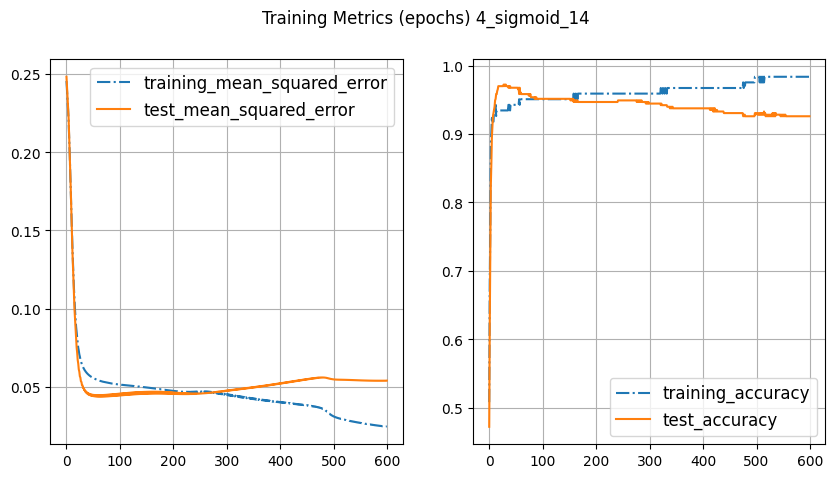

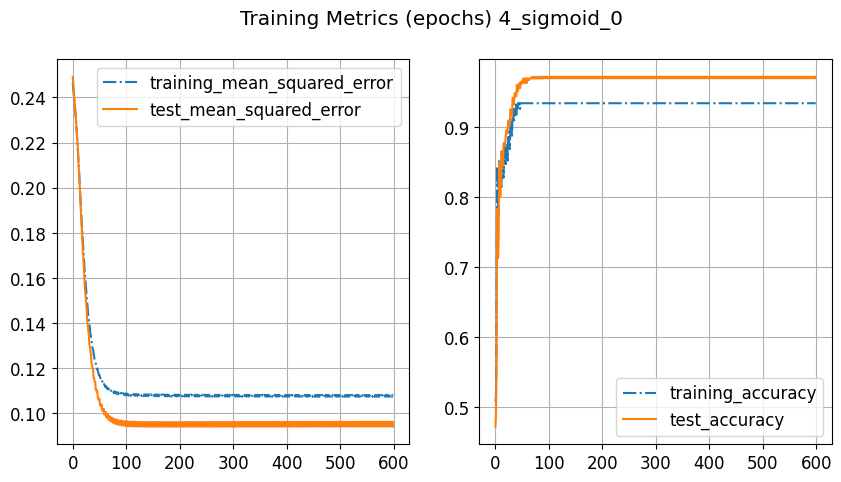

In [24]:
metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.accuracy]
for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('MONK3')
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['test_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'test_' + metrics[i].__name__],
                ax=ax[i], style=True, font_size=12)

In [25]:
dic_list = []
for dummy in interesting_model:
    dic = {}
    dic[dummy['top_name'] + 'tmse'] = dummy['stats']['training_mean_squared_error']
    dic[dummy['top_name'] + 'vmse'] = dummy['stats']['test_mean_squared_error']
    dic[dummy['top_name'] + 'tmee'] = dummy['stats']['training_accuracy']
    dic[dummy['top_name'] + 'vmee'] = dummy['stats']['test_accuracy']
    dic_list.append(pd.DataFrame(dic))
    
for i in dic_list:
    fig = px.line(i)
    fig.show()

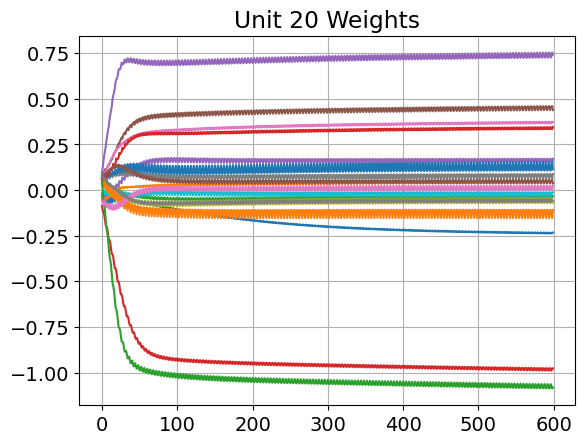

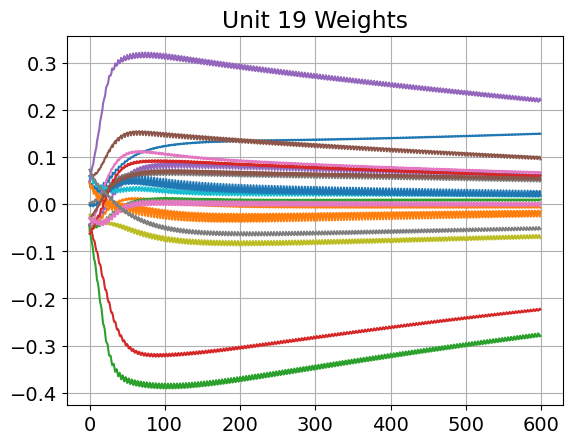

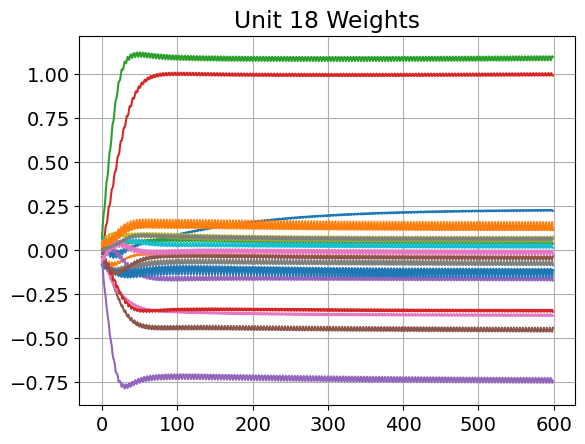

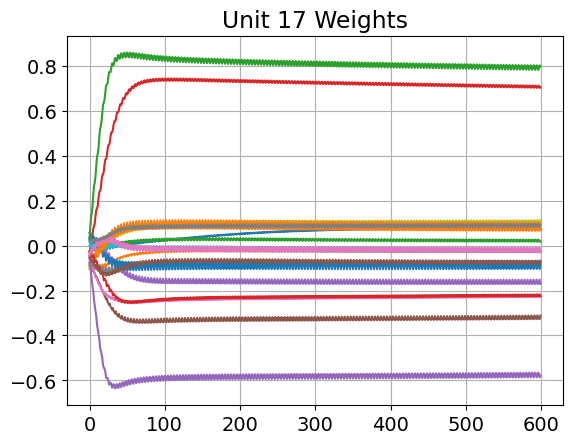

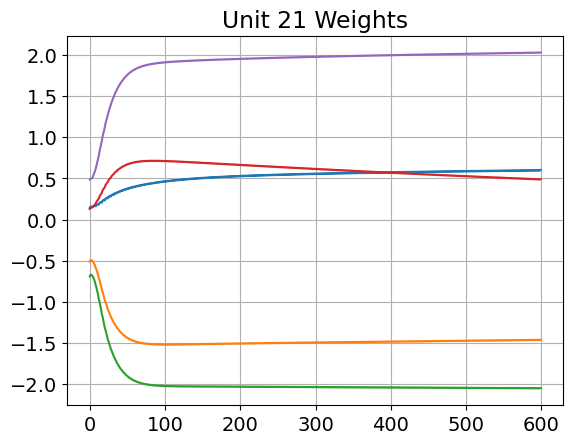

In [26]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights', legend=False)